In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [4]:
sns.set_context(context='talk')

In [5]:
from util import fetch_data_if_not_exist

files = [f"steinmetz_part{i}.npz" for i in range(3)]
urls = [
    "https://osf.io/agvxh/download",
    "https://osf.io/uv3mw/download",
    "https://osf.io/ehmw2/download",
]

for file_name, url in zip(files, urls):
    fetch_data_if_not_exist(file_name, url)

In [6]:
# @title Data loading
alldata = np.array([])
for file in files:
    data = np.load(file, allow_pickle=True)["dat"] # np.load(file).files = ["dat"]
    alldata = np.hstack((alldata, data))


In [7]:
dat = alldata[12]

In [15]:
len(np.round(dat['feedback_time'][10:20],2))

10

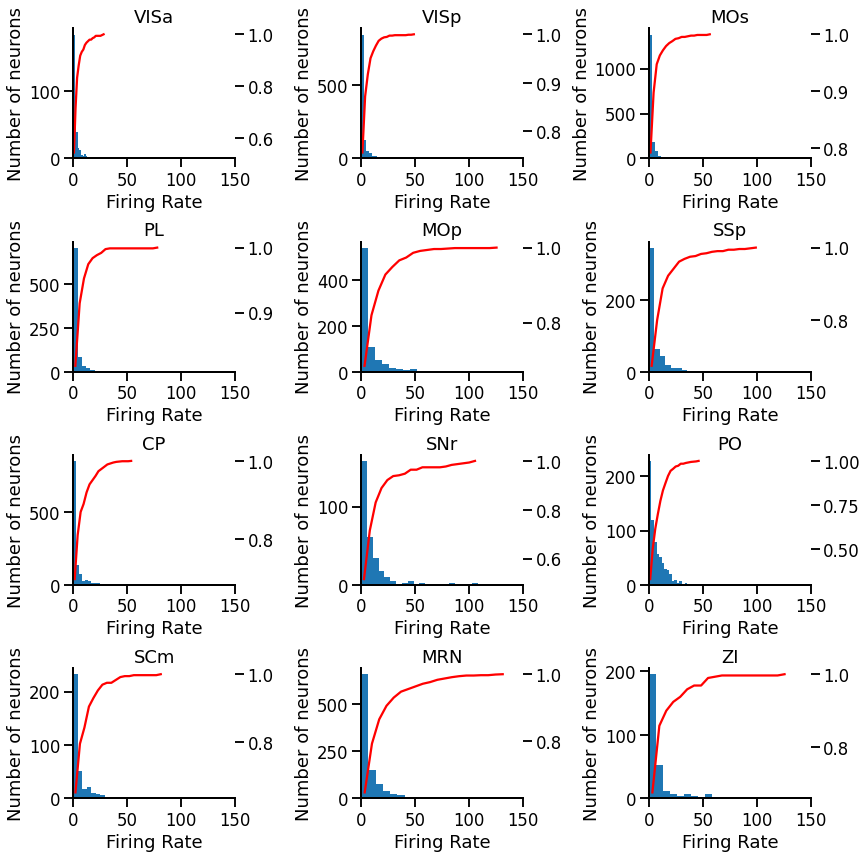

In [96]:
#フィードバック前○○秒の発火頻度をプロットする
dt = dat['bin_size']  # 0.01
NT = dat['spks'].shape[-1] #250

bin_wid = 30


reg = ['VISa','VISp','MOs','PL','MOp','SSp','CP','SNr','PO','SCm','MRN','ZI']
#フィードバックされた時間を取り出す
#ひとまず試行は全試行を対象にする
#その時間の200ミリ秒前と200ミリ秒後について発火頻度の平均をニューロンごとに算出してヒストグラムに描く

fig = plt.figure(figsize=(12,12))
for a in range(len(reg)):
    #特定の領野の試行数×時間の配列を作る
    x1 = 0
    for i in range(39):
        x2 = 0
        dat = alldata[i]
        reg_ind = np.where(dat['brain_area']==reg[a])[0] #領野のインデックス
        time_bin = np.arange(-500,2000,10)
        fb = np.round(dat['feedback_time'],2)*1000 #報酬がもらえた時間(10ミリ秒単位に直す)
        fb_ind_bin = np.zeros(fb.shape).astype(int).reshape(-1)
        for j in range(len(dat['feedback_time'])):
            if fb[j] < 2000:
                fb_ind_bin[j] = np.where(time_bin == fb[j])[0]
            else:
                fb_ind_bin[j] = 0


        #1試行ずつ特定の時間窓の発火頻度の時系列を取り出す
        if x2 == 0 and len(reg_ind) > 0: #初回かつ対象となる領野のニューロンが1つ以上あるときのみ
            spks_seq = np.zeros((len(reg_ind),1))

        for k in range(len(dat['feedback_time'])):
            if fb_ind_bin[k] != 0 and len(reg_ind) > 0:
                spks_seq = np.hstack((spks_seq,np.mean(1/dt * dat['spks'][reg_ind][:,k,fb_ind_bin[k]-bin_wid:fb_ind_bin[k]],axis=1).reshape(len(reg_ind),1)))

        #試行間平均
        if x1 == 0 and len(reg_ind) > 0: #初回のみ
            frate_ave = np.mean(spks_seq,axis=1)
            x1 = x1 + 1
        elif x1 > 0 and len(reg_ind) > 0:
            frate_ave = np.concatenate([frate_ave,np.mean(spks_seq,axis=1)],axis=0)

    ax = plt.subplot(4,3,a+1)
    n, bins, patches = ax.hist(frate_ave,bins=20)
    ax.set_xlabel('Firing Rate')
    ax.set_ylabel('Number of neurons')
    ax.set_xlim(0,150)
    # ax.set_ylim(0,700)
    ax.set_title(reg[a])

    # 第2軸用値の算出
    y2 = np.add.accumulate(n) / n.sum()
    x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]

    # 第2軸のプロット
    ax2 = ax.twinx()
    lines = ax2.plot(x2, y2, ls='-', color='r', label='Cumulative ratio')
    #ax2.grid(visible=False)
    # ax.legend()

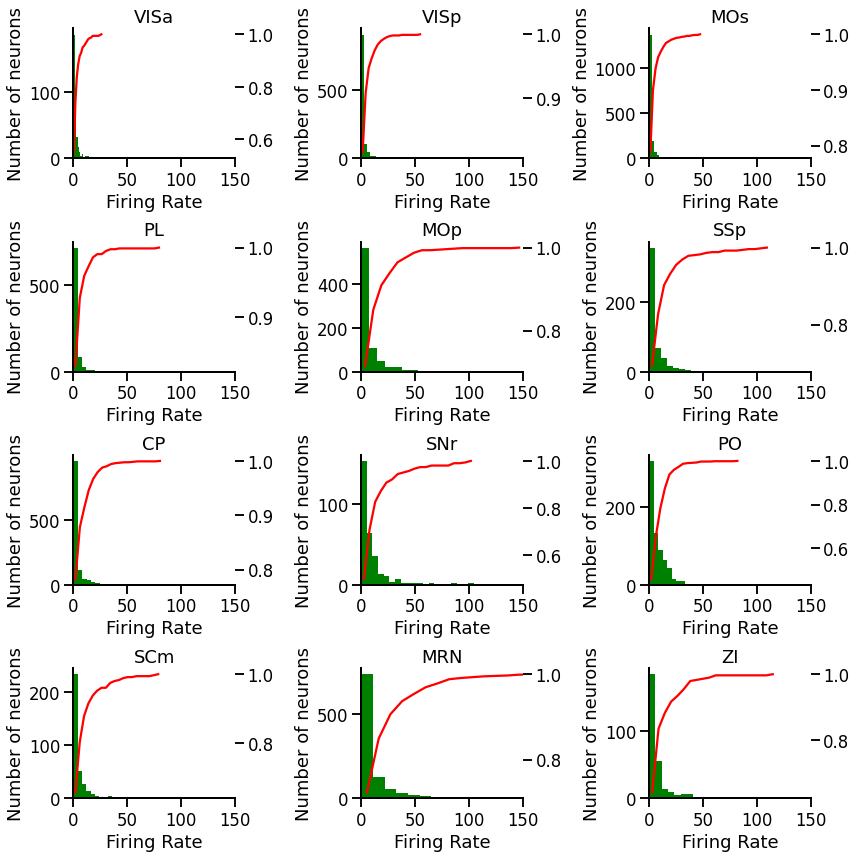

In [95]:
#フィードバック後○○秒の発火頻度をプロットする
dt = dat['bin_size']  # 0.01
NT = dat['spks'].shape[-1] #250

bin_wid = 30


reg = ['VISa','VISp','MOs','PL','MOp','SSp','CP','SNr','PO','SCm','MRN','ZI']
#フィードバックされた時間を取り出す
#ひとまず試行は全試行を対象にする
#その時間の200ミリ秒前と200ミリ秒後について発火頻度の平均をニューロンごとに算出してヒストグラムに描く

fig = plt.figure(figsize=(12,12))
for a in range(len(reg)):
    #特定の領野の試行数×時間の配列を作る
    x1 = 0
    for i in range(39):
        x2 = 0
        dat = alldata[i]
        reg_ind = np.where(dat['brain_area']==reg[a])[0] #領野のインデックス
        time_bin = np.arange(-500,2000,10)
        fb = np.round(dat['feedback_time'],2)*1000 #報酬がもらえた時間(10ミリ秒単位に直す)
        fb_ind_bin = np.zeros(fb.shape).astype(int).reshape(-1)
        for j in range(len(dat['feedback_time'])):
            if fb[j] < 2000:
                fb_ind_bin[j] = np.where(time_bin == fb[j])[0]
            else:
                fb_ind_bin[j] = 0


        #1試行ずつ特定の時間窓の発火頻度の時系列を取り出す
        if x2 == 0 and len(reg_ind) > 0: #初回かつ対象となる領野のニューロンが1つ以上あるときのみ
            spks_seq = np.zeros((len(reg_ind),1))

        for k in range(len(dat['feedback_time'])):
            if fb_ind_bin[k] != 0 and len(reg_ind) > 0:
                spks_seq = np.hstack((spks_seq,np.mean(1/dt * dat['spks'][reg_ind][:,k,fb_ind_bin[k]:fb_ind_bin[k]+bin_wid],axis=1).reshape(len(reg_ind),1)))

        #試行間平均
        if x1 == 0 and len(reg_ind) > 0: #初回のみ
            frate_ave = np.mean(spks_seq,axis=1)
            x1 = x1 + 1
        elif x1 > 0 and len(reg_ind) > 0:
            frate_ave = np.concatenate([frate_ave,np.mean(spks_seq,axis=1)],axis=0)

    ax = plt.subplot(4,3,a+1)
    n, bins, patches = ax.hist(frate_ave,bins=20,color='green')
    ax.set_xlabel('Firing Rate')
    ax.set_ylabel('Number of neurons')
    ax.set_xlim(0,150)
    # ax.set_ylim(0,700)
    ax.set_title(reg[a])

    # 第2軸用値の算出
    y2 = np.add.accumulate(n) / n.sum()
    x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]

    # 第2軸のプロット
    ax2 = ax.twinx()
    lines = ax2.plot(x2, y2, ls='-', color='r', label='Cumulative ratio')
    #ax2.grid(visible=False)
    # ax.legend()

In [66]:
np.mean(spks_seq,axis=1).shape

(72,)